In [1]:
import numpy as np
import torch
from matplotlib import pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

from beartype import beartype as typechecker
import jaxtyping as jxt
from typing import Optional, Callable, Union, List, Tuple, Literal


def typecheck(func):
    return jxt.jaxtyped(typechecker=typechecker)(func)


Array = np.ndarray
Tensor = torch.Tensor

Bool = Union[bool, np.bool_]
Int = Union[int, np.integer]
Float = Union[float, np.floating]
Real = Union[Int, Float]
Int64 = np.int64
Float64 = np.float64

TorchDevice = Union[str, torch.device]


class Int64Tensor:
    """Torch tensor of int64 ("long")."""

    def __class_getitem__(cls, shape):
        return jxt.Int64[Tensor, shape]


class Float32Tensor:
    """Torch tensor of float32 ("float")."""

    def __class_getitem__(cls, shape):
        return jxt.Float32[Tensor, shape]

In [19]:
class Cells:
    @typecheck
    def __init__(
        self,
        *,
        pixels: Float32Tensor["n_pixels dimension"],
        seeds: Float32Tensor["n_seeds dimension"],
        volumes: Float32Tensor["n_seeds"],
        pixel_volumes: Optional[Float32Tensor["n_pixels"]] = None,
        hardness: Real | Float32Tensor["n_seeds"] = 2,
    ):
        self.pixels = pixels
        self.seeds = seeds

        if type(volumes) in (int, float):
            volumes = volumes * torch.ones_like(seeds[:, 0])
        # Add an extra volume for the medium
        volumes = torch.cat([1 - volumes.sum().view(1), volumes])
        self.cell_volumes = volumes

        if type(hardness) in (int, float):
            hardness = hardness * torch.ones_like(seeds[:, 0])
        self.hardness = hardness

        if pixel_volumes is None:
            pixel_volumes = torch.ones_like(pixels[:, 0]) * (1 / len(pixels))
        self.pixel_volumes = pixel_volumes

    @property
    @typecheck
    def n_pixels(self) -> int:
        return self.pixels.shape[0]

    @property
    @typecheck
    def n_seeds(self) -> int:
        return self.seeds.shape[0]

    @property
    @typecheck
    def n_cells(self) -> int:
        return self.n_seeds + 1

    @property
    @typecheck
    def dim(self) -> int:
        return self.seeds.shape[1]

    @property
    @typecheck
    def costs(self) -> Float32Tensor["n_cells n_pixels"]:
        x_i = self.seeds.view(self.n_seeds, 1, self.dim)
        y_j = self.pixels.view(1, self.n_pixels, self.dim)

        D2_ij = ((x_i - y_j) ** 2).sum(dim=2)  # (n_cells, n_pixels)
        h_i = self.hardness.view(self.n_seeds, 1)
        C_ij = D2_ij ** (h_i / 2)

        # Add a line of 0s at the top of the cost matrix, representing the medium
        return torch.cat([torch.zeros(1, self.n_pixels), C_ij], dim=0)

    @typecheck
    def solve_ot(self, *, n_iter=100, stop=None, method="L-BFGS-B"):

        C_ij = self.costs
        a_i = self.cell_volumes.view(self.n_cells)
        b_j = self.pixel_volumes.view(self.n_pixels)

        if method == "L-BFGS-B":

            def dual_cost(seed_potentials: Float32Tensor["n_seeds"]):
                # f_i : add a 0 for the medium to seed_potentials
                print(".", end="", flush=True)
                f_i = torch.cat(
                    [torch.zeros_like(seed_potentials[:1]), seed_potentials]
                )
                g_j = (C_ij - f_i.view(self.n_cells, 1)).min(dim=0).values
                assert f_i.shape == (self.n_cells,)
                assert g_j.shape == (self.n_pixels,)
                res = (a_i * f_i).sum() + (b_j * g_j).sum()
                return res

            seed_potentials = torch.zeros_like(a_i[1:])
            seed_potentials.requires_grad = True
            optimizer = torch.optim.LBFGS(
                [seed_potentials], max_iter=n_iter, line_search_fn="strong_wolfe"
            )

            def closure():
                optimizer.zero_grad()
                loss = - dual_cost(seed_potentials)
                loss.backward()
                return loss
            
            for _ in range(n_iter):
                optimizer.step(closure)

            f_i = torch.cat([torch.zeros(1), seed_potentials])
            g_j = (C_ij - f_i.view(self.n_cells, 1)).min(dim=0).values
            eps = 0

        if method == "sinkhorn":
            loga_i = a_i.log().view(self.n_cells, 1)
            logb_j = b_j.log().view(1, self.n_pixels)

            f_i = torch.zeros_like(a_i)
            g_j = torch.zeros_like(b_j)

            R = C_ij @ b_j
            assert R.shape == (self.n_cells,)
            R = (R * a_i).sum()

            f_i = C_ij @ b_j - 0.5 * R
            g_j = C_ij.T @ a_i - 0.5 * R

            first = 4
            last = 0.001
            temperatures = np.geomspace(first, last, n_iter + 1)

            for it, eps in enumerate(temperatures):
                if stop is not None and it >= stop:
                    break
                ft_i = -eps * (
                    (g_j.view(1, self.n_pixels) - C_ij) / eps + logb_j
                ).logsumexp(dim=1)
                gt_j = -eps * (
                    (f_i.view(self.n_cells, 1) - C_ij) / eps + loga_i
                ).logsumexp(dim=0)
                f_i = 0.5 * (f_i + ft_i)
                g_j = 0.5 * (g_j + gt_j)

                if False:
                    K = f_i[0]
                    f_i = f_i - K
                    g_j = g_j + K

        self.temperature = eps
        self.cell_potentials = f_i.detach()
        self.pixel_potentials = g_j.detach()

    @typecheck
    def transport_plan(self) -> Float32Tensor["n_cells n_pixels"]:
        a_i = self.cell_volumes.view(self.n_cells, 1)
        f_i = self.cell_potentials.view(self.n_cells, 1)
        b_j = self.pixel_volumes.view(1, self.n_pixels)
        g_j = self.pixel_potentials.view(1, self.n_pixels)
        C_ij = self.costs
        if self.temperature > 0:
            P_ij = torch.exp((f_i + g_j - C_ij) / self.temperature) * a_i * b_j
        else:
            P_ij = (f_i + g_j >= C_ij) * a_i * b_j
        return P_ij

    @property
    @typecheck
    def cell_volumes_(self) -> Float32Tensor["n_cells"]:
        cell_volumes = self.pixel_labels.bincount(minlength=self.n_cells)
        cell_volumes = cell_volumes / len(self.pixels)
        return cell_volumes


    @typecheck
    def convergence_metrics(self):
        P_ij = self.transport_plan()
        v_i = P_ij.sum(dim=1)
        w_j = P_ij.sum(dim=0)
        relative_errors_i = (v_i / self.cell_volumes - 1).abs()
        relative_errors_j = (w_j / self.pixel_volumes - 1).abs()

        C_ij = self.costs
        a_i = self.cell_volumes
        f_i = self.cell_potentials
        b_j = self.pixel_volumes
        g_j = self.pixel_potentials

        dual_cost = (a_i * f_i).sum() + (b_j * g_j).sum()
        dual_constraint = (
            C_ij - f_i.view(self.n_cells, 1) - g_j.view(1, self.n_pixels)
        ).min()

        relative_volume_errors = (self.cell_volumes_ / self.cell_volumes - 1).abs()

        return {
            "cell_marginals": relative_errors_i.max(),
            "pixel_marginals": relative_errors_j.max(),
            "cell_volumes_max": relative_volume_errors.max(),
            "cell_volumes_mean": relative_volume_errors.mean(),
            "dual_cost": dual_cost,
            # "dual_constraint": dual_constraint,
        }

    @property
    @typecheck
    def pixel_labels(self) -> Int64Tensor["n_pixels"]:
        costs = self.costs
        costs = costs - self.cell_potentials.view(self.n_cells, 1)
        if self.temperature > 0:
            costs = costs / self.temperature
            costs = costs - self.cell_volumes.view(self.n_cells, 1).log()
        return costs.argmin(dim=0)

    @typecheck
    def pixel_colors(self, *, hard=True) -> Float32Tensor["n_pixels n_color_channels"]:
        if hard:
            pixel_colors = self.colors[self.pixel_labels]
        else:
            P_ij = self.transport_plan()
            pixel_colors = P_ij.T @ self.colors
            pixel_colors = pixel_colors / self.pixel_volumes.view(-1, 1)

        return pixel_colors.clamp(0, 1)

    def display_potentials(self, *, iter_stop=[(None, None)], ax=None):

        return ax

    def display_pixel_map(self, *, ax=None):
        if ax is None:
            fig, ax = plt.subplots()

        return ax

    def display_all(self, iter_stop=[(None, None)]):
        fig, axes = plt.subplots(3, 1, figsize=(8, 5))

        images_soft, images_hard, convergence_metrics = [], [], []
        for k, (n_iter, stop) in enumerate(iter_stop):
            if n_iter is not None:
                self.solve_ot(n_iter=n_iter, stop=stop)

            t = (k + 1) / len(iter_stop)
            x = self.pixels.squeeze().numpy()
            costs = self.costs
            costs = costs - self.cell_potentials.view(self.n_cells, 1)
            costs = costs.detach()

            colors = self.colors.cpu().numpy()
            colors[0] = (0.0, 0.0, 0.0)
            colors = t * colors + (1 - t) * 0.8
            for i in range(costs.shape[0]):
                axes[0].plot(
                    x,
                    costs[i].numpy(),
                    color=colors[i],
                    label=f"Cell {i}",
                    linewidth=1 if t == 1 else 0.15,
                )

            images_soft.append(self.pixel_colors(hard=False).view(1, -1, 3))
            images_hard.append(self.pixel_colors(hard=True).view(1, -1, 3))
            convergence_metrics.append(self.convergence_metrics())

        axes[0].set_ylabel("Adjusted costs   $c(x_i, \cdot) - f_i$")
        pix_size = 1 / len(x)
        axes[0].set_xlim(x.min() - pix_size / 2, x.max() + pix_size / 2)
        ymin = costs.min()
        axes[0].set_ylim(2 * ymin, -2 * ymin)

        if len(iter_stop) == 1:
            image = torch.cat(images_soft + images_hard, dim=0)
        else:
            white = torch.ones(1, self.n_pixels, 3)
            image = torch.cat(images_soft + [white] + images_hard, dim=0)
        axes[1].imshow(
            image,
            aspect="auto",
        )
        # Use square pixels
        # ax.set_aspect(1)
        if len(iter_stop) == 1:
            axes[1].set_aspect("equal")
        # Display a pixel grid on top of the image,
        axes[1].set_xticks([i + 0.5 for i in range(self.n_pixels - 1)])
        axes[1].set_yticks([])
        # Remove tick labels
        axes[1].set_xticklabels([])
        axes[1].grid(True, which="both", color=(0,) * 3, linestyle="-", linewidth=0.5)

        plt.subplots_adjust(top=1.2)

        if len(iter_stop) > 1:

            # Turn the convergence metrics from a list of dicts into a dict of lists
            convergence_metrics = {
                key: [d[key] for d in convergence_metrics]
                for key in convergence_metrics[0]
            }
            # Plot the convergence metrics
            for i, (key, values) in enumerate(convergence_metrics.items()):
                axes[2].plot(values, label=key)
            axes[2].set_yscale("log")
            axes[2].legend()

        plt.tight_layout()

    @property
    @typecheck
    def colors(self) -> Float32Tensor["n_cells n_color_channels"]:
        return torch.tensor(
            [
                (1, 1, 1),
                (1, 0, 0),
                (0, 0.8, 0),
                (0, 0, 1),
            ]
        )

...............................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................tensor([0.5000, 0.3000, 0.1000, 0.1000]) tensor([0.4851, 0.3069, 0.1089, 0.0990])
{'cell_marginals': tensor(0.9703), 'pixel_marginals': tensor(1.), 'cell_volumes_max': tensor(0.0891), 'cell_volumes_mean': tensor(0.0380), 'dual_cost': tensor(0.0048)}


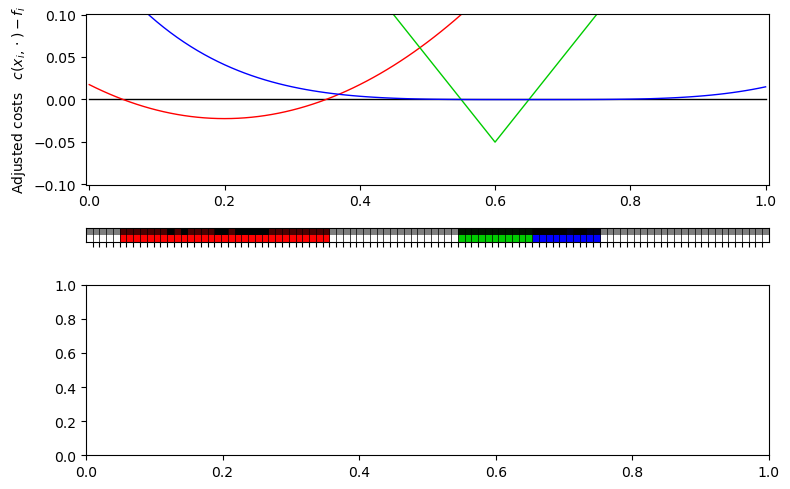

In [26]:
cells = Cells(
    pixels=torch.linspace(0, 1, 101).view(-1, 1),
    seeds=torch.tensor([0.2, 0.6, 0.65]).view(-1, 1),
    volumes=torch.tensor([0.3, 0.1, 0.1]),
    hardness=torch.tensor([2.0, 1.0, 4.0]),
)

cells.solve_ot(n_iter=100, stop=None)
print(cells.cell_volumes, cells.cell_volumes_)
print(cells.convergence_metrics())
cells.display_all()

In [30]:
#n_iter = 101
#cells.display_all(iter_stop=[(n_iter, int(s * n_iter)) for s in np.linspace(0, 1, 101)])

.....

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

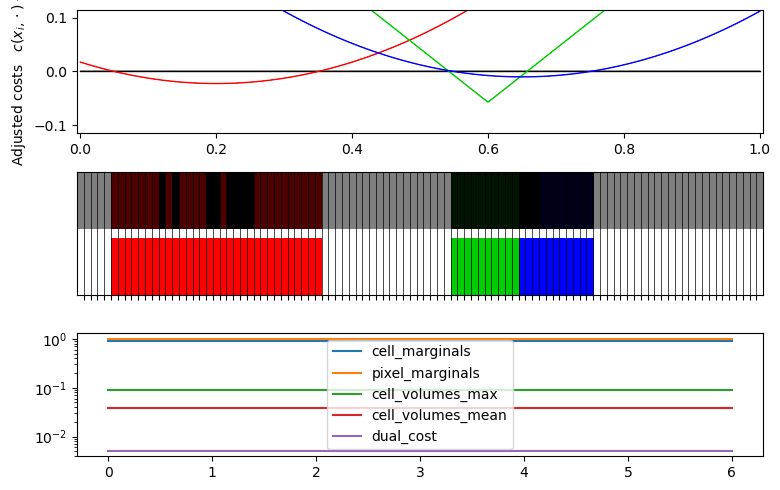

In [22]:
cells.display_all(
    iter_stop=[(10 * n_iter, None) for n_iter in [1,2,5,10,20,50,100]]
)